# Introduction

In this notebook we are doing exploratory data analysis on the KinCoRe database, extracting relevant informations from the KinCoRe dataset and featurize it to make the dataset for the modeling.

The workflow is as follows:
1. load pakages, directory, and dataset
2.

In [6]:
# general data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management packages
import csv, sys
import os
import os.path
import pickle

# cheminformatics packages
from rdkit import DataStructs
from rdkit.Chem import Descriptors, PandasTools, rdFingerprintGenerator, Draw
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from mordred import Calculator, descriptors, ABCIndex, Framework

# data preparation

## loading data
1. load data
2. split ligandtype and ligand so that we won't have multiple ligand/type in one row
3. explode the data

In [ ]:
cd ../data

In [11]:
data = pd.read_table('kincore.tab') # load data
data

,Organism,Group,Gene,UniprotID,PDB,Method,Resolution,Rfac,FreeRfac,DomainBoundary,...,DisorderedResiActivationLoop,SpatialLabel,DihedralLabel,C-helix,Ligand,LigandType,DFG_Phe,Phosphorylation,Mutations,ProteinName
0,Aplysia californica,CAMK,TWITCHIN,Q16980_APLCA,1KOBA,XRAY,2.3,0.200,0.282,47-302,...,0,DFGin,ABAminus,out,No_ligand,No_ligand,189,None,None,Twitchin-like protein
1,Aplysia californica,CAMK,TWITCHIN,Q16980_APLCA,1KOBB,XRAY,2.3,0.200,0.282,47-302,...,0,DFGin,ABAminus,out,No_ligand,No_ligand,189,None,None,Twitchin-like protein
2,Arabidopsis thaliana,CAMK,CIPK23,CIPKN_ARATH,4CZTA,XRAY,2.3,0.179,0.234,31-286,...,0,DFGin,BLBminus,out,CPS:61316,Type1,173,None,None,CBL-interacting serine/threonine-protein kinas...
3,Arabidopsis thaliana,CAMK,CIPK23,CIPKN_ARATH,4CZTB,XRAY,2.3,0.179,0.234,31-286,...,0,DFGin,BLBminus,out,CPS:61314,Type1,173,None,None,CBL-interacting serine/threonine-protein kinas...
4,Arabidopsis thaliana,CAMK,CIPK23,CIPKN_ARATH,4CZUA,XRAY,1.9,0.194,0.233,31-286,...,0,DFGin,BLBminus,out,CPS:61321,Type1,173,None,T190D,CBL-interacting serine/threonine-protein kinas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10666,Zea mays,CMGC,ACK2,CSK2A_MAIZE,1ZOGA,XRAY,2.3,0.239,0.294,34-319,...,0,DFGin,BLAminus,in,K37:60501 K37:60502,Type1 Type1,171,None,None,Casein kinase II subunit alpha
10667,Zea mays,OTHER,DRIK1,C0P4K9_MAIZE,6CPYA,XRAY,1.7,0.200,0.215,226-487,...,16,DFGout,BBAminus,in,No_ligand,No_ligand,375,None,None,Protein kinase superfamily protein
10668,Zea mays,OTHER,DRIK1,C0P4K9_MAIZE,6CPYB,XRAY,1.7,0.200,0.215,226-487,...,15,DFGout,BBAminus,out,No_ligand,No_ligand,375,None,None,Protein kinase superfamily protein
10669,Zea mays,OTHER,DRIK1,C0P4K9_MAIZE,6EASA,XRAY,2.0,0.209,0.251,226-487,...,16,DFGout,BBAminus,out,J3A:501,Type1,375,None,None,Protein kinase superfamily protein


in the data we can see several points:
1. organisms varies, not just homo sapiens/kinase --> filter to only homo sapiens
2. we see that the data contains a lot of ligand types instead of our usual types (1, 1.5 front, 1.5 back, 2, 3, allosteric), which means that some contains several ligands at once. this means we have to explode the data and separate by ligand types
3. separate by : for the ligand names
4. get the first 3 letters in the column 'Ligand'
5. drop  value No_Ligand
6. get ligand identifiers
7. put into a list and sort alphabetically! (important, otherwise the series of the smiles and its name will be chaotic)

In [12]:
#load data
data = pd.read_table('kincore.tab')

#only homo sapiens organism
data = data[data['Organism']=='Homo sapiens']

#split and explode ligand classification
data['LigandType'] = data['LigandType'].str.split(' ')
data['Ligand'] = data['Ligand'].str.split(' ')
data = data.explode(['LigandType', 'Ligand'])

# edit ligand names
## remove no_ligand
data = data.drop(data[data['Ligand'].isin(['No_ligand'])].index)

#split ligand
lig_split = data['Ligand'].str.split(':')

#create new dataframe for ligand names
data_ligand = pd.DataFrame(data[['LigandType', 'Ligand']]).reset_index().drop(columns=['index'])
data_ligand['lig_id'] = pd.DataFrame([lig_split.iloc[i][0] for i in range(len(lig_split))])
data_ligand['lig_at'] = pd.DataFrame([lig_split.iloc[i][1] for i in range(len(lig_split))])
data_ligand = data_ligand.drop(columns=['Ligand'])
data_ligand = data_ligand.dropna().drop_duplicates()
data_ligand = data_ligand.drop(data_ligand[data_ligand['lig_id'].str.match('A[A-Z]P')].index)
data_ligand = data_ligand.drop(data_ligand[data_ligand['LigandType']=='none'].index)

data_ligand

,LigandType,lig_id,lig_at
0,Type1,0XZ,60501
1,Type1,XM1,1
2,Type1,XM1,2
3,Type1,SMY,60001
4,Type1,SMY,60002
...,...,...,...
8248,Type1,VZJ,901
8250,Type1,VZG,901
8252,Type1,UNL,901
8254,Type1,AGS,901


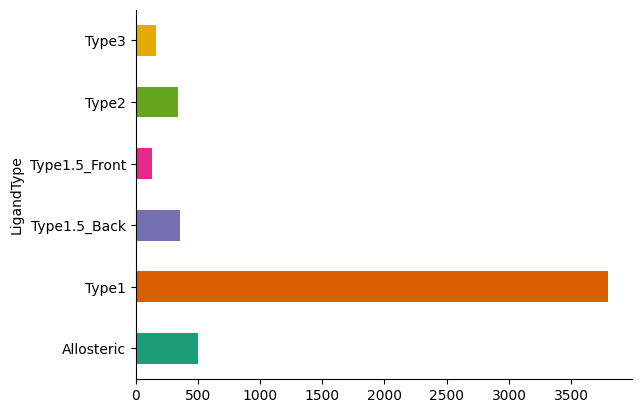

In [13]:
# @title LigandType

from matplotlib import pyplot as plt
import seaborn as sns
data_ligand.groupby('LigandType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data_ligand.LigandType.unique()

array(['Type1', 'Type1.5_Front', 'Allosteric', 'Type1.5_Back', 'Type2',
       'Type3'], dtype=object)

## get ligand smiles

used from https://github.com/MunibaFaiza/cheminformatics/blob/main/ligand-id-to-str-in-pdb-format.ipynb

### fetch data

In [14]:
ligand_df = pd.DataFrame(data_ligand, columns=['lig_id']).drop_duplicates()
ligand_df = ligand_df.sort_values('lig_id')
ligand_df

,lig_id
7606,00J
1383,01I
7124,01P
6076,027
5181,02A
...,...
5810,ZZF
5809,ZZG
975,ZZK
465,ZZL


In [ ]:
!pwd

/Users/nadawahyu/Documents/Uni/Master/Forschungspraktikum_2/data


In [15]:
# defining output dir
lig_dir = 'ligand-dir'
#ligand_df.to_csv('ligands_id.csv')

#making and changing to ligands-sdf directory
#os.mkdir(lig_dir)
os.chdir(lig_dir)

In [16]:
for i in data_ligand['lig_id'].unique():
    cmd = os.system('wget'+' '+'https://files.rcsb.org/ligands/download/'+i+'_ideal.sdf')
    print(i)

print('done')


0XZ
XM1
SMY
SMR
SM9
0RF
CQU
CQW
XFE
WFE
EX4
SMH
IQO
G4Q
G4H
L1Z
0R4
6S1
G4K
G4T
G4N
L1W
UCE
UC8
G95
I5S
L20
GVP
X39
X37
G93
G96
G98
NM7
3FV
AQE
AQ5
M77
BI8
8PV
SIX
ZS2
EJS
29X
W4D
W4G
8PR
KZQ
AFM
AFV
ZSO
QRW
8DJ
Q1Y
8DS
BA1
AN2
SGV
STU
1F8
U35
2A2
BI4
J30
LI8
39Z
517
464
JNZ
JOZ
JPZ
BI3
JMZ
CKG
61Y
62O
63L
63E
UCN
LY4
BI2
BI1
MP6
ABQ
3RW
3S1
9BD
253
8H1
8I1
3Q0
3Q1
3RC
537
ADE
ADN
SYP
MH4
P47
A06
MJF
21O
R1S
R2S
78W
31S
RF4
AZ7
3Q2
3Q3
3Q4
3Q5
3Q6
MP7
2V9
DRN
MI1
AGS
I5G
VX6
6J9
A03
L9L
YTP
1SB
2SB
3SB
4SB
S69
IQB
NVX
NVV
S3N
4L7
8BQ
495
4W1
504
J4B
EE4
L9M
L9N
796
35R
SKE
E3Z
3KZ
LW4
PDS
XXF
Y3I
07U
AFU
C58
PZW
3L0
LG8
5VS
EX6
EZJ
PCG
EXZ
3NC
3ND
B4V
B4Y
B5G
J0P
86K
07Q
0HD
3J7
VFS
HFS
Y27
H52
4KH
4KK
4TW
6U1
6U2
8UV
07R
65R
B4J
86G
81G
O1V
3SG
1WU
O1S
VFA
5YS
Z8O
P01
2NR
2NS
QCT
2NK
583
584
72B
5FI
1RJ
1SK
FZ8
FZ9
F76
FS7
3T3
FS9
MMG
GMG
86H
5DN
5E1
ZZL
CC3
FH3
9YQ
0C3
0C8
NHI
NL4
6F2
F8Z
2JZ
EML
0FY
L0C
L0D
L0E
L0F
L0G
9A6
A0H
XU1
X6D
YM4
4QV
COA
400
0C0
0BX
0C9
NHJ
NHU
NRM
D36
5GX


In [ ]:
cd ligand-dir

/Users/nadawahyu/Documents/Uni/Master/Forschungspraktikum_2/data/ligand-dir


In [17]:
join_cmd = os.system("cat *.sdf > ligands-03.sdf")
joined_ligands = "ligands-03.sdf"

In [18]:
# converting SDF to SMILES using RDKit

def converter(file_name):
    sdf_file = Chem.SDMolSupplier(file_name)

    out_file = open('smiles-03.txt', "w")
    for mol in sdf_file:
        if mol is not None:             # avoiding compounds that cannot be loaded.
            smi = Chem.MolToSmiles(mol)
            out_file.write(f"{mol.GetProp('_Name')};{smi}\n")
    out_file.close()
if __name__ == "__main__":
    converter(joined_ligands)
    print("Generated SMILES are present in smiles.txt file")

[13:13:30] Explicit valence for atom # 12 N greater than permitted
[13:13:30] ERROR: Could not sanitize molecule ending on line 9136
[13:13:30] ERROR: Explicit valence for atom # 12 N greater than permitted
[13:13:30] Explicit valence for atom # 21 N greater than permitted
[13:13:30] ERROR: Could not sanitize molecule ending on line 69075
[13:13:30] ERROR: Explicit valence for atom # 21 N greater than permitted
[13:13:31] Explicit valence for atom # 1 N greater than permitted
[13:13:31] ERROR: Could not sanitize molecule ending on line 131188
[13:13:31] ERROR: Explicit valence for atom # 1 N greater than permitted
[13:13:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[13:13:31] ERROR: Could not sanitize molecule ending on line 223845
[13:13:31] ERROR: Explicit valence for atom # 0 O, 3, is greater than permitted
[13:13:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[13:13:31] ERROR: Could not sanitize molecule ending on line 223962
[13:13:31] ERROR

Generated SMILES are present in smiles.txt file


### load data

In [24]:
cd ligand-dir

/content/drive/MyDrive/kinase/data/ligand-dir


In [25]:
lig_smiles = pd.read_csv('smiles-03.txt', header=None, sep=';').rename(columns=({0:'lig_id', 1:'lig_smiles'}))
lig_smiles

,lig_id,lig_smiles
0,00J,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...
1,01I,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1
2,01P,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1
3,027,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...
4,02A,O=C(O)[C@@H]1CCN1
...,...,...
6984,ZZF,Cc1ccc(Oc2ccnc(Nc3ccc(S(N)(=O)=O)cc3)c2)c(C)n1
6985,ZZG,COc1cc(Nc2cc(Oc3cc(C)c(C)nc3-c3ccccn3)ccn2)cc(...
6986,ZZK,NC(=O)c1ccc(-c2cc(-c3cccc4c3OCO4)cnc2N)cc1
6987,ZZL,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...


In [27]:
cd ..

/content/drive/MyDrive/kinase/data


In [28]:
# new data
data_clean = lig_smiles.merge(data_ligand, left_on='lig_id', right_on='lig_id')
data_clean = data_clean.drop(columns=['lig_id'])
data_clean = data_clean.dropna().drop_duplicates().reset_index().drop(columns=['index']) # drop the nan so that we only have type 1, 1.5, 2, 3 and allosteric ligandtype & drop the duplicates
#data_clean = data_clean.set_index('lig_smiles')
data_clean

data_clean.to_csv('data_clean-03.csv', index=False)

In [29]:
data_clean

,lig_smiles,LigandType,lig_at
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1
...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001


## get molecular fingerprints with mordred

In [ ]:
os.chdir('../../data')

In [30]:
data_clean = pd.read_csv('data_clean-03.csv')
#data_clean = data_clean.set_index('lig_smiles')
data_clean

,lig_smiles,LigandType,lig_at
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1
...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001


In [31]:
# method 2: calculate all available descriptors, output as pandas dataframe
# check ignore_3D as here we are using 2D structures (SMILES) as the descriptor source
mols = [Chem.MolFromSmiles(i) for i in data_clean.lig_smiles]
calc = Calculator(descriptors, ignore_3D=True)
mordred_out = calc.pandas(mols)

 25%|██▌       | 1338/5270 [03:31<10:21,  6.33it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 26%|██▌       | 1350/5270 [03:34<21:10,  3.08it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 5270/5270 [14:07<00:00,  6.22it/s]


In [32]:
import pickle

#outfile_path = "../../data/"

pickle_out = open("mordred_2D-03.pkl", "wb")
pickle.dump(mordred_out, pickle_out)
pickle_out.close()

In [46]:
mordred_out

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,4.467355,...,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,9.222222,7.500000
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,4.062355,...,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,7.111111,4.583333
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,4.062355,...,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,7.111111,4.583333
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,4.406929,...,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.5,7.083333
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,4.275407,...,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,9.222222,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,...,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,10.444444,7.305556
5266,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,...,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,10.444444,7.305556
5267,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,...,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,10.444444,7.305556
5268,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,...,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,10.444444,7.305556


In [48]:
# filtering out features with 0 only
mordred_out_1 = mordred_out.loc[:,mordred_out.apply(pd.Series.nunique) != 1]
mask = mordred_out_1.applymap(lambda x: isinstance(x, (int, float)))
mordred_out2 = mordred_out_1.where(mask)
mordred_out_noNA = mordred_out2.dropna(axis=1)

mordred_out_noNA

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,4.467355,4.354953,0.128087,...,7.034388,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,7.500000
1,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,4.062355,4.236366,0.192562,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
2,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,4.062355,4.236366,0.192562,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
3,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,4.406929,5.158087,0.161190,...,0.000000,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.083333
4,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,4.275407,4.411049,0.157537,...,6.529419,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,4.730242,0.139125,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5266,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,4.730242,0.139125,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5267,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,4.730242,0.139125,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5268,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,4.471126,4.730242,0.139125,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


In [50]:
data_mordred = pd.concat([data_clean, mordred_out_noNA], ignore_index=False, axis=1)
data_mordred.to_csv('data_mordred-03.csv', index=False)
data_mordred

,lig_smiles,LigandType,lig_at,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,...,7.034388,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,7.500000
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,...,0.000000,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.083333
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,...,6.529419,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


### separating allo and binding
logic:
- data_binding fp: all data which LigandType values are `type x`
- data_allo_fp: all data which LigandType values are `Allosteric` and those whose SMILES from `data_fp` that isn't in data_allo_fp will be labeled as `non-allo`

In [51]:
# load data
data_fp = pd.read_csv('data_mordred-03.csv')
data_fp

,lig_smiles,LigandType,lig_at,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,...,7.034388,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,7.500000
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,...,0.000000,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.083333
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,...,6.529419,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


In [63]:
data_fp.LigandType.unique()

array(['Type1.5_Back', 'Type1', 'Allosteric', 'Type1.5_Front', 'Type2',
       'Type3'], dtype=object)

In [53]:
data_binding_fp = data_fp[data_fp['LigandType']!='Allosteric']
data_binding_fp = data_binding_fp[data_binding_fp['LigandType']!='none'].reset_index().drop(columns=['index'])
data_binding_fp


,lig_smiles,LigandType,lig_at,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,0,1,45.033552,2.486988,4.905553,45.033552,1.324516,...,7.034388,10.469568,84.750063,461.195071,7.560575,4081,55,182.0,216.0,7.500000
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,2,0,28.466792,2.532439,4.962680,28.466792,1.293945,...,7.544861,10.229224,72.883345,296.032088,9.867736,1015,37,126.0,154.0,4.583333
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,0,0,43.138904,2.390528,4.781057,43.138904,1.348091,...,0.000000,10.351789,68.049732,428.196074,7.646358,3385,50,170.0,199.0,7.083333
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,0,1,36.178567,2.495953,4.988216,36.178567,1.292092,...,6.529419,10.341194,77.189895,381.227708,6.931413,2015,46,152.0,181.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


In [193]:
data_allo_fp = data_fp[data_fp['LigandType']=='Allosteric']

data_na = data_binding_fp.copy()
data_na = data_na.replace({
    'Type1.5_Back': 'non_allo',
    'Type1': 'non_allo',
    'Type1.5_Front': 'non_allo',
    'Type2': 'non_allo',
    'Type3': 'non_allo',
})
data_na

data_allo_fp = pd.concat([data_allo_fp, data_na])
#data_allo_fp = data_allo_fp.dropna().drop_duplicates()
data_allo_fp

,lig_smiles,LigandType,lig_at,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
5,O=C(O)[C@@H]1CCN1,Allosteric,509,1,1,7.300563,2.236068,4.472136,7.300563,1.042938,...,0.000000,8.750683,35.280476,101.047678,7.217691,44,5,32.0,35.0,1.611111
63,OCC1CC1,Allosteric,505,0,0,6.428639,2.214320,3.889451,6.428639,1.285728,...,7.070724,8.010028,48.538567,72.057515,5.542886,17,2,22.0,24.0,1.250000
64,OCC1CC1,Allosteric,510,0,0,6.428639,2.214320,3.889451,6.428639,1.285728,...,7.070724,8.010028,48.538567,72.057515,5.542886,17,2,22.0,24.0,1.250000
133,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Allosteric,61004,0,2,50.160383,2.424055,4.845295,50.160383,1.286164,...,6.823286,10.602045,90.124872,532.219844,8.063937,5771,62,210.0,246.0,8.305556
153,CCCCCCCCCCCCCCCCCCO[P@@](=O)(O)OC1CC[N+](C)(C)CC1,Allosteric,500,1,1,37.693142,2.333553,4.667106,37.693142,1.215908,...,0.000000,9.761521,65.265296,462.370672,5.504413,4312,34,138.0,144.0,7.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1390,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1392,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1389,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1001,1,0,44.089568,2.510581,4.966182,44.089568,1.296752,...,5.379897,10.553649,78.788838,476.085160,9.716024,3464,63,186.0,223.0,7.305556


<Axes: xlabel='LigandType', ylabel='count'>

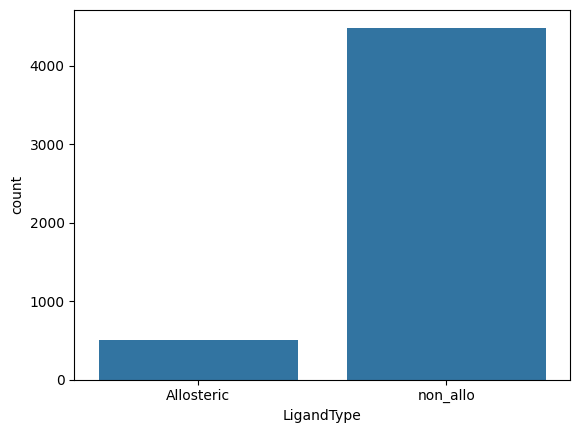

In [55]:
sns.countplot(x=data_allo_fp['LigandType'])

<Axes: xlabel='LigandType', ylabel='count'>

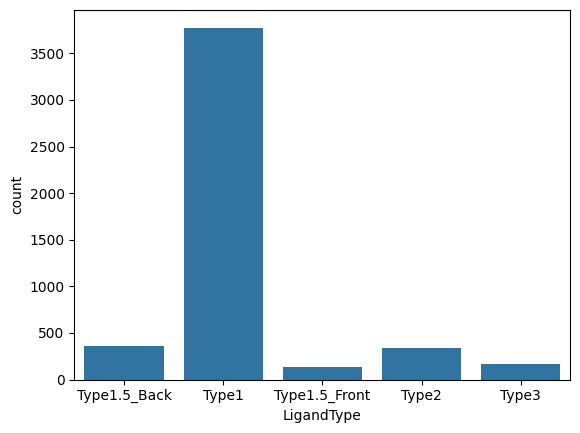

In [59]:
sns.countplot(x=data_binding_fp['LigandType'])

In [107]:
data_allo_fp.to_csv('data_allo_fp-03.csv')
data_binding_fp.to_csv('data_binding_fp-03.csv')

<Axes: xlabel='LigandType', ylabel='count'>

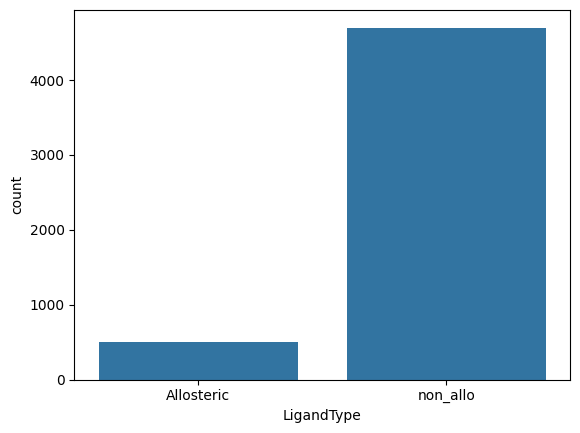

In [108]:
data_fa = pd.read_csv('data_allo_fp-03.csv')
sns.countplot(data_fa, x='LigandType')

## rdkit

In [109]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs

In [111]:
data_clean = pd.read_csv('data_clean-03.csv')
#data_clean = data_clean.set_index('lig_smiles')
data_clean

,lig_smiles,LigandType,lig_at
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1
...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001


### generate data_mol

In [124]:
data_clean

,lig_smiles,LigandType,lig_at
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1
...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001


In [121]:
data_clean.merge(data_mol)

,lig_smiles,LigandType,lig_at,lig_id
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,00J
1,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,00J
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,01I
3,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,01I
4,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,01I
...,...,...,...,...
9684,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,ZZL
9685,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,ZZL
9686,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,ZZL
9687,NC(=O)c1cnc2ccn(S(=O)(=O)c3ccccc3[N+](=O)[O-])...,Type1,2347,ZZY


In [ ]:
pd.concat()

In [133]:
data_desc = data_clean.copy()
#data_mol = data_mol.drop(['lig_id'], axis=1)
#data = data.drop(columns=['lig_id'])
#data_mol['mol_obj'] = [Chem.MolFromSmiles(i) for i in data_mol['lig_smiles']]
PandasTools.AddMoleculeColumnToFrame(data_desc, smilesCol='lig_smiles', molCol='mol', includeFingerprints=True)

data_desc.to_csv('data_desc.csv', index=False)

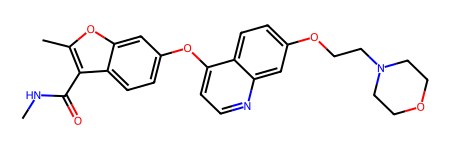

In [132]:
data_desc['mol'][0]

### load data_desc

,lig_smiles,LigandType,lig_at,mol
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,
...,...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,

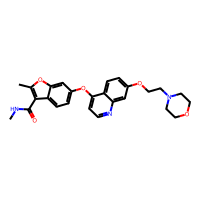
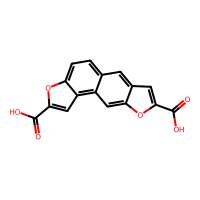
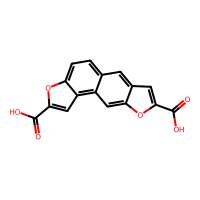
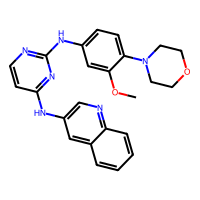
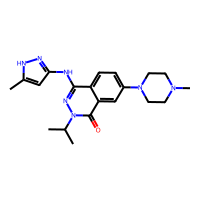
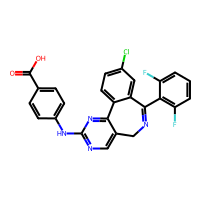
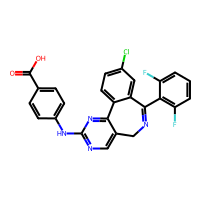
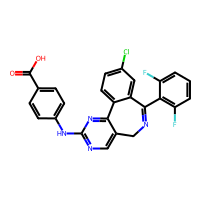
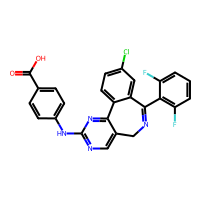
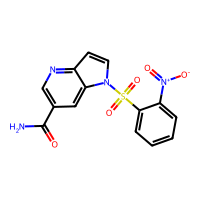

In [137]:
data_desc = pd.read_csv('data_desc.csv')#.drop(['Unnamed: 0'], axis=1)
PandasTools.AddMoleculeColumnToFrame(data_desc, smilesCol='lig_smiles', molCol='mol', includeFingerprints=True)

data_desc

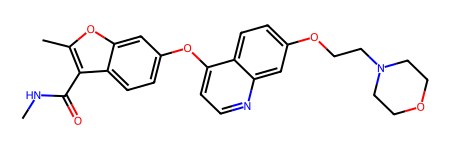

In [138]:
data_desc['mol'][0]

In [139]:
mols = [i for i in data_desc['mol']]

### get descriptors

In [140]:
from rdkit.Chem import Descriptors

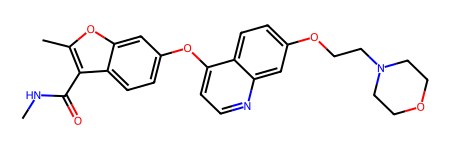

In [141]:
data_desc['mol'][0]

In [142]:
# taken from greg landrum's blog https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule

        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [144]:
desc = [getMolDescriptors(i) for i in mols]
d_desc = pd.DataFrame(desc)
d_desc

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,434.302,461.195071,176,...,0,0,0,0,0,0,0,0,0,0
1,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,288.170,296.032088,108,...,0,0,0,0,0,0,0,0,0,0
2,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,288.170,296.032088,108,...,0,0,0,0,0,0,0,0,0,0
3,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,404.304,428.196074,162,...,0,0,0,0,0,0,0,0,0,0
4,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,354.268,381.227708,148,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5266,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5267,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5268,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0


In [198]:
# filtering out features with 0 only
rdkit_out_1 = d_desc.loc[:,d_desc.apply(pd.Series.nunique) != 1]
mask = rdkit_out_1.applymap(lambda x: isinstance(x, (int, float)))
rdkit_out2 = rdkit_out_1.where(mask)
rdkit_out_noNA = rdkit_out2.dropna(axis=1)

rdkit_out_noNA

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,434.302,461.195071,176,...,0,0,0,0,0,0,0,0,0,0
1,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,288.170,296.032088,108,...,0,0,0,0,0,0,0,0,0,0
2,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,288.170,296.032088,108,...,0,0,0,0,0,0,0,0,0,0
3,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,404.304,428.196074,162,...,0,0,0,0,0,0,0,0,0,0
4,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,354.268,381.227708,148,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5266,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5267,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0
5268,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,461.750,476.085160,168,...,0,0,0,0,0,0,0,0,0,0


In [200]:
data_descriptors = pd.concat([data_desc, rdkit_out_noNA], axis=1).drop(['mol',], axis=1)#.set_index('lig_smiles')
data_descriptors.to_csv('data_descriptors.csv', index=False)
data_descriptors

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


### separating allo and binding
logic:
- data_binding fp: all data which LigandType values are `type x`
- data_allo_fp: all data which LigandType values are `Allosteric` and those whose SMILES from `data_fp` that isn't in data_allo_fp will be labeled as `non-allo`

In [201]:
# load data
data_descriptors = pd.read_csv('data_descriptors.csv')
data_descriptors

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5266,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5267,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5268,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


In [202]:
data_binding_desc = data_descriptors[data_descriptors['LigandType']!='Allosteric']
data_binding_desc = data_binding_desc[data_binding_desc['LigandType']!='none'].reset_index().drop(columns=['index'])
data_binding_desc


,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type1.5_Back,2169,12.178672,12.178672,0.173135,-0.173135,0.442423,14.411765,461.518,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,332,11.019783,11.019783,0.138918,-1.142046,0.584168,11.454545,296.234,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type1,60001,5.632207,5.632207,0.490670,0.490670,0.468745,13.718750,428.496,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,13.089887,0.036424,-0.065059,0.722645,15.535714,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


In [204]:
data_allo_desc = data_descriptors[data_descriptors['LigandType']=='Allosteric']

data_na = data_binding_desc.copy()
data_na = data_na.replace({
    'Type1.5_Back': 'non_allo',
    'Type1': 'non_allo',
    'Type1.5_Front': 'non_allo',
    'Type2': 'non_allo',
    'Type3': 'non_allo',
})
data_na

data_allo_desc = pd.concat([data_allo_desc, data_na])
data_allo_desc = data_allo_desc.dropna().drop_duplicates()
data_allo_desc

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
5,O=C(O)[C@@H]1CCN1,Allosteric,509,9.919074,9.919074,0.250000,-0.730324,0.464852,28.857143,101.105,...,0,0,0,0,0,0,0,0,0,0
63,OCC1CC1,Allosteric,505,8.206019,8.206019,0.416667,0.416667,0.474736,23.400000,72.107,...,0,0,0,0,0,0,0,0,0,0
64,OCC1CC1,Allosteric,510,8.206019,8.206019,0.416667,0.416667,0.474736,23.400000,72.107,...,0,0,0,0,0,0,0,0,0,0
133,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Allosteric,61004,13.935889,13.935889,0.082839,-4.539718,0.393599,14.692308,532.570,...,0,0,0,0,0,0,0,0,0,0
153,CCCCCCCCCCCCCCCCCCO[P@@](=O)(O)OC1CC[N+](C)(C)CC1,Allosteric,500,12.109842,12.109842,0.145576,-3.899576,0.114812,18.838710,462.676,...,0,0,0,0,0,0,0,0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4765,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4766,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
4767,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


In [205]:
data_allo_desc.to_csv('data_allo_desc-03.csv')
data_binding_desc.to_csv('data_binding_desc-03.csv')

In [ ]:
import seaborn as sns

<Axes: xlabel='LigandType', ylabel='count'>

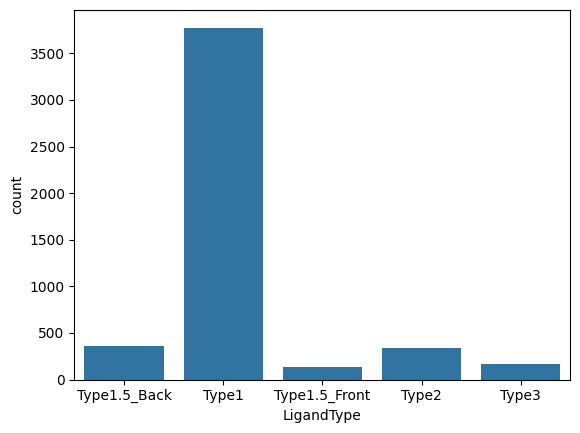

In [207]:
sns.countplot(x=data_binding_desc['LigandType'])

<Axes: xlabel='LigandType', ylabel='count'>

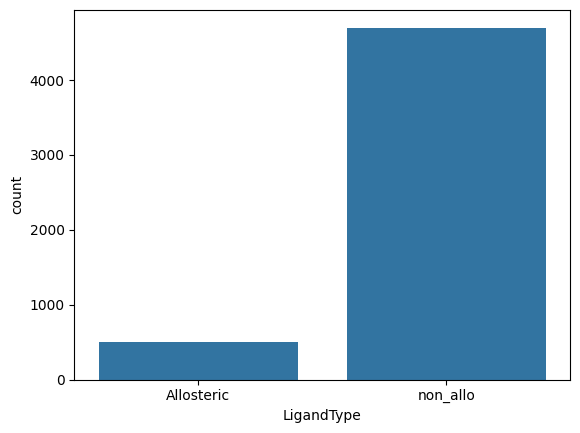

In [208]:
sns.countplot(x=data_allo_desc['LigandType'])